# Eda Teams

In [1]:
# Librerias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

In [2]:
# Cargar los datos
game_data_limpia_df = pd.read_csv(r'F:\Desktop\Dani_ unificado\SmartPro_Analytics\EDA\data\game_clean.csv')
team_data_limpia_df = pd.read_csv(r'F:\Desktop\Dani_ unificado\SmartPro_Analytics\EDA\data\team_clean.csv')
team_details_data_limpia_df = pd.read_csv(r'F:\Desktop\Dani_ unificado\SmartPro_Analytics\EDA\data\team_details.csv', encoding='latin1')
game_info_limpia_df = pd.read_csv(r'F:\Desktop\Dani_ unificado\SmartPro_Analytics\EDA\data\game_info_clean.csv')

In [3]:
# Unir los datos relevantes para el análisis
team_info = team_data_limpia_df.merge(team_details_data_limpia_df, left_on='id', right_on='team_id')
games_info = game_data_limpia_df.merge(team_info, left_on='team_id_home', right_on='id')


In [4]:
# Definición de equipos por conferencia
conferencia_este = [
    "Boston Celtics", "Brooklyn Nets", "New York Knicks", "Philadelphia 76ers", "Toronto Raptors",
    "Chicago Bulls", "Cleveland Cavaliers", "Detroit Pistons", "Indiana Pacers", "Milwaukee Bucks",
    "Atlanta Hawks", "Charlotte Hornets", "Miami Heat", "Orlando Magic", "Washington Wizards"
]

conferencia_oeste = [
    "Dallas Mavericks", "Houston Rockets", "Memphis Grizzlies", "New Orleans Pelicans", "San Antonio Spurs",
    "Denver Nuggets", "Minnesota Timberwolves", "Oklahoma City Thunder", "Portland Trail Blazers", "Utah Jazz",
    "Golden State Warriors", "Los Angeles Clippers", "Los Angeles Lakers", "Phoenix Suns", "Sacramento Kings"
]


In [5]:
# Crear un diccionario para almacenar los equipos por conferencia
equipos_nba = {
    "Este": conferencia_este,
    "Oeste": conferencia_oeste
}

In [6]:
# Función para asignar conferencia basada en el diccionario `equipos_nba`
def asignar_conferencia(equipo):
    for conferencia, equipos in equipos_nba.items():
        if equipo in equipos:
            return conferencia
    return 'Desconocida'  # En caso de que un equipo no esté en ninguna conferencia definida

In [7]:
# Calcular KPIs basados en team_name_home
# 1. Win Ratio
games_info['win_home'] = games_info['wl_home'].apply(lambda x: 1 if x == 'W' else 0)
games_info['win_away'] = games_info['wl_away'].apply(lambda x: 1 if x == 'W' else 0)
win_ratio_home = games_info.groupby('team_name_home')['win_home'].mean()
win_ratio_away = games_info.groupby('team_name_away')['win_away'].mean()
win_ratio = (win_ratio_home + win_ratio_away) / 2
win_ratio_df = win_ratio.reset_index()
win_ratio_df.columns = ['Team', 'Win_Ratio']

# 2. Average Points Scored
avg_points_scored_home = games_info.groupby('team_name_home')['pts_home'].mean()
avg_points_scored_away = games_info.groupby('team_name_away')['pts_away'].mean()
avg_points_scored = (avg_points_scored_home + avg_points_scored_away) / 2
avg_points_scored_df = avg_points_scored.reset_index()
avg_points_scored_df.columns = ['Team', 'Avg_Points_Scored']

# 3. Average Points Allowed
avg_points_allowed_home = games_info.groupby('team_name_home')['pts_away'].mean()
avg_points_allowed_away = games_info.groupby('team_name_away')['pts_home'].mean()
avg_points_allowed = (avg_points_allowed_home + avg_points_allowed_away) / 2
avg_points_allowed_df = avg_points_allowed.reset_index()
avg_points_allowed_df.columns = ['Team', 'Avg_Points_Allowed']

# 4. Attendance (promediado por equipo en lugar de por juego para la consolidación)
attendance_info = game_info_limpia_df.merge(games_info[['game_id', 'team_name_home', 'team_name_away']], on='game_id')
attendance_info_home = attendance_info.groupby('team_name_home')['attendance'].mean().reset_index()
attendance_info_home.columns = ['Team', 'Avg_Attendance']
attendance_info_away = attendance_info.groupby('team_name_away')['attendance'].mean().reset_index()
attendance_info_away.columns = ['Team', 'Avg_Attendance']
attendance_info = (attendance_info_home.set_index('Team') + attendance_info_away.set_index('Team')) / 2
attendance_info = attendance_info.reset_index()


In [8]:
# Agregar la columna de Conferencia basada en la función `asignar_conferencia`
win_ratio_df['Conference'] = win_ratio_df['Team'].apply(asignar_conferencia)

In [9]:
# Consolidar todos los KPIs en un solo DataFrame
kpi_df = win_ratio_df.merge(avg_points_scored_df, on='Team')\
                     .merge(avg_points_allowed_df, on='Team')\
                     .merge(attendance_info, on='Team')


In [10]:
# Exportar a CSV
kpi_df.to_csv(r'F:\Desktop\Dani_ unificado\SmartPro_Analytics\EDA\data\team_kpis.csv', index=False)

print("Archivo CSV consolidado exportado correctamente.")

Archivo CSV consolidado exportado correctamente.


In [12]:
# Análisis de KPIs por conferencia y equipos dentro de cada conferencia
kpis_por_conferencia = kpi_df.groupby('Conference').agg({
    'Win_Ratio': 'mean',
    'Avg_Points_Scored': 'mean',
    'Avg_Points_Allowed': 'mean',
    'Avg_Attendance': 'mean'
})

# Análisis de KPIs por equipos dentro de una conferencia específica (por ejemplo, Este)
equipos_este = kpi_df[kpi_df['Conference'] == 'Este']
kpis_por_equipo_este = equipos_este.groupby('Team').agg({
    'Win_Ratio': 'mean',
    'Avg_Points_Scored': 'mean',
    'Avg_Points_Allowed': 'mean',
    'Avg_Attendance': 'mean'
})

# Análisis de KPIs por equipos dentro de una conferencia específica (por ejemplo, Oeste)
equipos_oeste = kpi_df[kpi_df['Conference'] == 'Oeste']
kpis_por_equipo_oeste = equipos_oeste.groupby('Team').agg({
    'Win_Ratio': 'mean',
    'Avg_Points_Scored': 'mean',
    'Avg_Points_Allowed': 'mean',
    'Avg_Attendance': 'mean'
})

# Imprimir resultados de análisis
print("KPIs por conferencia:")
print(kpis_por_conferencia)

print("\nKPIs por equipos en la Conferencia Este:")
print(kpis_por_equipo_este)

print("\nKPIs por equipos en la Conferencia Oeste:")
print(kpis_por_equipo_oeste)

KPIs por conferencia:
             Win_Ratio  Avg_Points_Scored  Avg_Points_Allowed  Avg_Attendance
Conference                                                                   
Desconocida   0.441897         100.994540          102.657951     8544.643042
Este          0.488657         102.875249          103.226542    15792.882603
Oeste         0.503760         104.340157          104.258468    15689.528662

KPIs por equipos en la Conferencia Este:
                     Win_Ratio  Avg_Points_Scored  Avg_Points_Allowed  \
Team                                                                    
Atlanta Hawks         0.495816         102.980786          103.273647   
Boston Celtics             NaN                NaN                 NaN   
Brooklyn Nets         0.457022         106.934369          108.450748   
Charlotte Hornets     0.470381         102.770435          104.088025   
Chicago Bulls         0.514262         102.283955          101.840907   
Cleveland Cavaliers        NaN     

## EDA

In [13]:
# Cargar el archivo CSV consolidado
kpi_df = pd.read_csv(r'F:\Desktop\Dani_ unificado\SmartPro_Analytics\EDA\data\team_kpis.csv')

In [14]:
# Dividir kpi_df por conferencias
kpi_df_este = kpi_df[kpi_df['Conference'] == 'Este']
kpi_df_oeste = kpi_df[kpi_df['Conference'] == 'Oeste']


### Gráfico 1
"Win Ratio por equipo en la Conferencia"
Este analiza la proporción de juegos ganados por cada equipo dentro de esa conferencia específica. El Win Ratio es un indicador comúnmente utilizado en deportes como la NBA para evaluar el desempeño de los equipos en términos de victorias respecto a los juegos jugados.

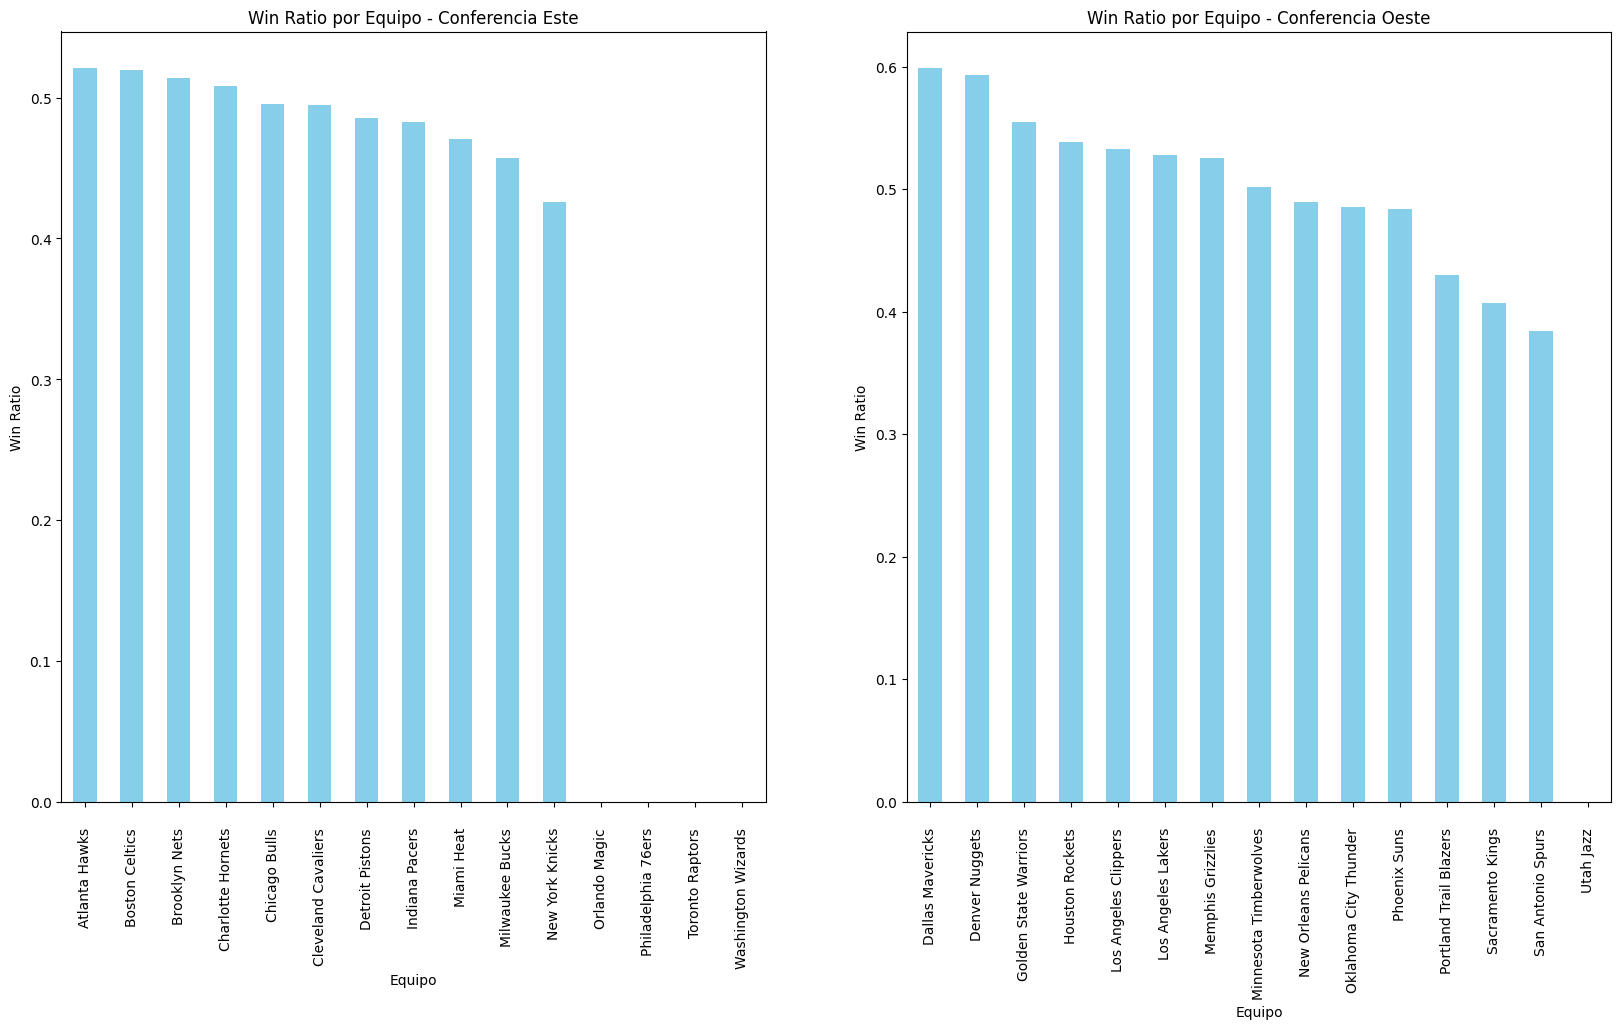

In [17]:
# Crear subplots para ambos gráficos lado a lado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Gráfico 1: Win Ratio por equipo en la Conferencia Este
kpi_df_este.sort_values(by='Win_Ratio', ascending=False).plot(kind='bar', x='Team', y='Win_Ratio', color='skyblue', legend=False, ax=ax1)
ax1.set_title('Win Ratio por Equipo - Conferencia Este')
ax1.set_xlabel('Equipo')
ax1.set_ylabel('Win Ratio')
ax1.set_xticklabels(kpi_df_este['Team'], rotation=90)
ax1.tick_params(axis='x', which='major', pad=15)  # Ajustar espacio entre etiquetas x

# Gráfico 2: Win Ratio por equipo en la Conferencia Oeste
kpi_df_oeste.sort_values(by='Win_Ratio', ascending=False).plot(kind='bar', x='Team', y='Win_Ratio', color='skyblue', legend=False, ax=ax2)
ax2.set_title('Win Ratio por Equipo - Conferencia Oeste')
ax2.set_xlabel('Equipo')
ax2.set_ylabel('Win Ratio')
ax2.set_xticklabels(kpi_df_oeste['Team'], rotation=90)
ax2.tick_params(axis='x', which='major', pad=15)  # Ajustar espacio entre etiquetas x

# Guardar figura y mostrar los gráficos
plt.savefig('win_ratio_conferencias_lado_a_lado.png')
plt.show()

Los gráficos anteriores muestran el Win Ratio (porcentaje de victorias) de cada equipo en la Conferencia Este y Oeste de la NBA. Estos gráficos permiten comparar el rendimiento de los equipos en términos de victorias dentro de sus respectivas conferencias.

#### Qué Mide el Gráfico

1. **Win Ratio por Equipo**:
   - **Conferencia Este**: El primer gráfico muestra el porcentaje de victorias de cada equipo de la Conferencia Este.
   - **Conferencia Oeste**: El segundo gráfico muestra el porcentaje de victorias de cada equipo de la Conferencia Oeste.

#### Importancia del Indicador

1. **Evaluación del Rendimiento Global**:
   - **Comparación Interna**: Permite a los equipos compararse dentro de su propia conferencia y ver cómo se posicionan respecto a sus competidores directos.
   - **Comparación Externa**: Facilita la comparación entre las dos conferencias, proporcionando una visión global del rendimiento en términos de victorias.

2. **Estrategia y Tácticas de Juego**:
   - **Identificación de Equipos Fuertes**: Equipos con un alto Win Ratio suelen ser los más competitivos y pueden ser considerados favoritos para avanzar a los playoffs y tener éxito en la postemporada.
   - **Análisis de Competencia**: Equipos y analistas pueden usar este indicador para estudiar a los equipos más fuertes y adaptar sus estrategias y tácticas de juego.

3. **Motivación y Moral del Equipo**:
   - **Indicador de Éxito**: Un alto porcentaje de victorias suele estar asociado con una buena moral del equipo y un alto nivel de confianza.
   - **Mejora Continua**: Equipos con un Win Ratio bajo pueden usar esta métrica para identificar la necesidad de cambios y mejoras en su juego y estrategia.

4. **Planificación de Futuras Temporadas**:
   - **Decisiones de Gestión**: La dirección del equipo puede usar esta información para tomar decisiones sobre fichajes, cambios de entrenadores y otras decisiones estratégicas.




### Gráfico 2
"Puntos Promedio Anotados por Equipo" - Indicador del rendimiento defensivo
Analiza el rendimiento defensivo de los equipos en función de los puntos promedio permitidos.

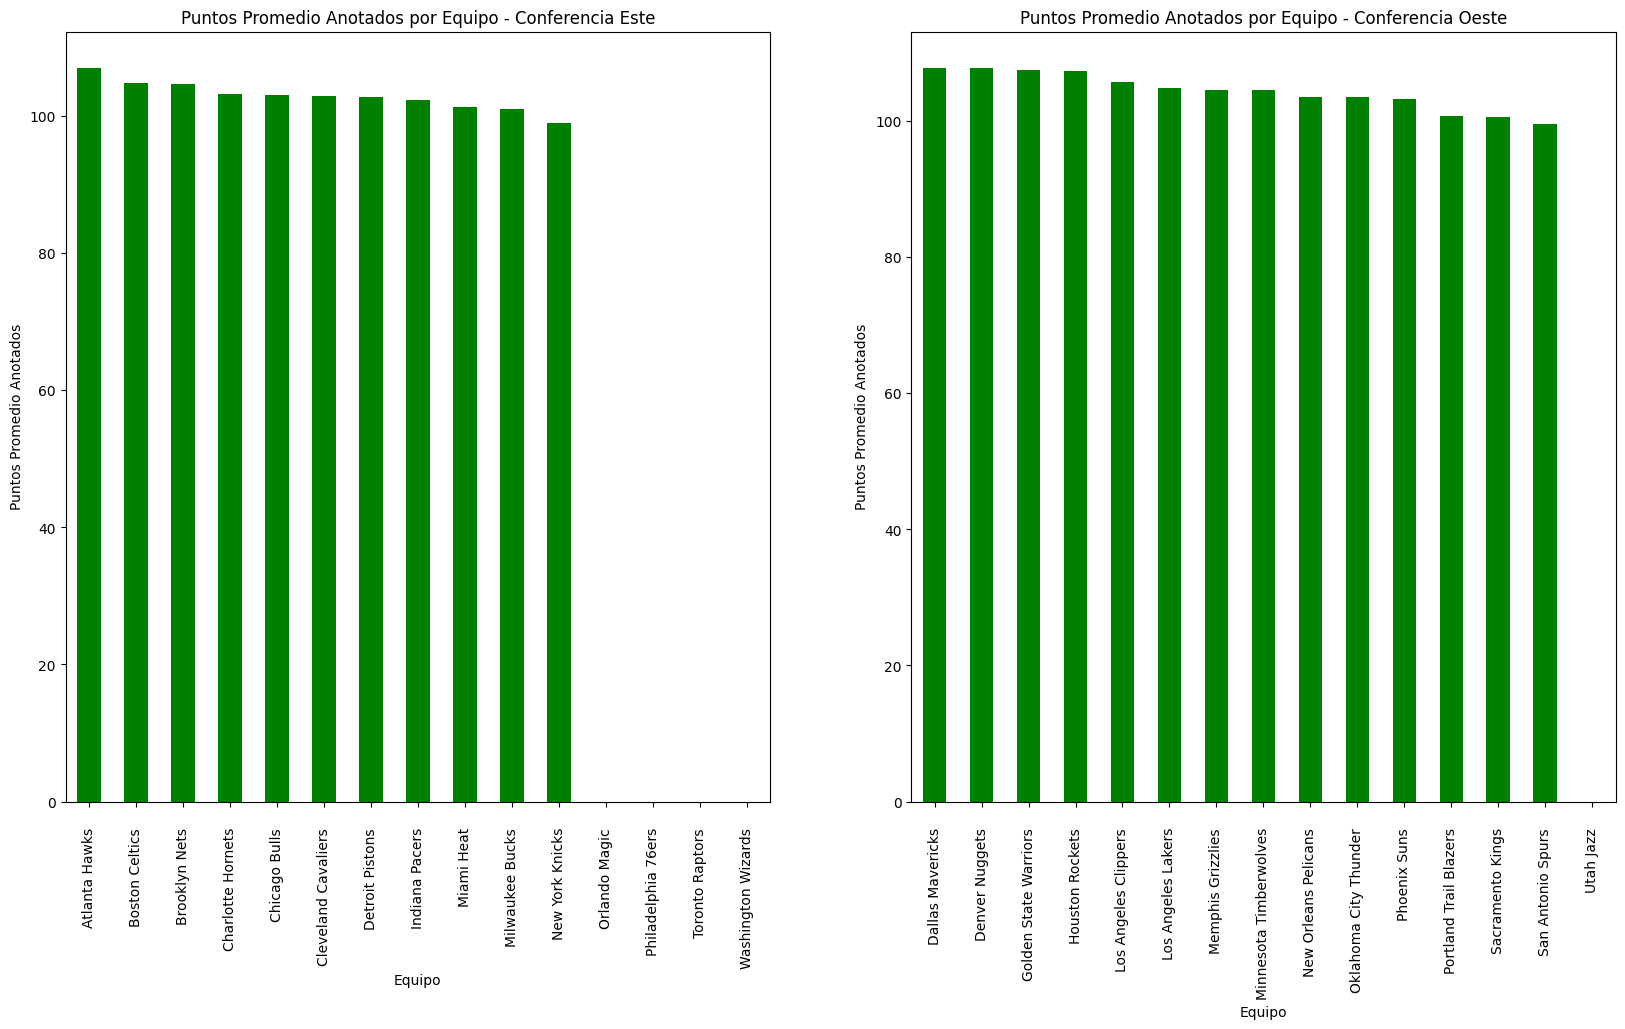

In [18]:
# Crear subplots para ambos gráficos lado a lado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Gráfico 1: Average Points Scored por equipo en la Conferencia Este
kpi_df_este.sort_values(by='Avg_Points_Scored', ascending=False).plot(kind='bar', x='Team', y='Avg_Points_Scored', color='green', legend=False, ax=ax1)
ax1.set_title('Puntos Promedio Anotados por Equipo - Conferencia Este')
ax1.set_xlabel('Equipo')
ax1.set_ylabel('Puntos Promedio Anotados')
ax1.set_xticklabels(kpi_df_este['Team'], rotation=90)
ax1.tick_params(axis='x', which='major', pad=15)  # Ajustar espacio entre etiquetas x

# Gráfico 2: Average Points Scored por equipo en la Conferencia Oeste
kpi_df_oeste.sort_values(by='Avg_Points_Scored', ascending=False).plot(kind='bar', x='Team', y='Avg_Points_Scored', color='green', legend=False, ax=ax2)
ax2.set_title('Puntos Promedio Anotados por Equipo - Conferencia Oeste')
ax2.set_xlabel('Equipo')
ax2.set_ylabel('Puntos Promedio Anotados')
ax2.set_xticklabels(kpi_df_oeste['Team'], rotation=90)
ax2.tick_params(axis='x', which='major', pad=15)  # Ajustar espacio entre etiquetas x

# Guardar figura y mostrar los gráficos
plt.savefig('avg_points_scored_conferencias_lado_a_lado.png')
plt.show()


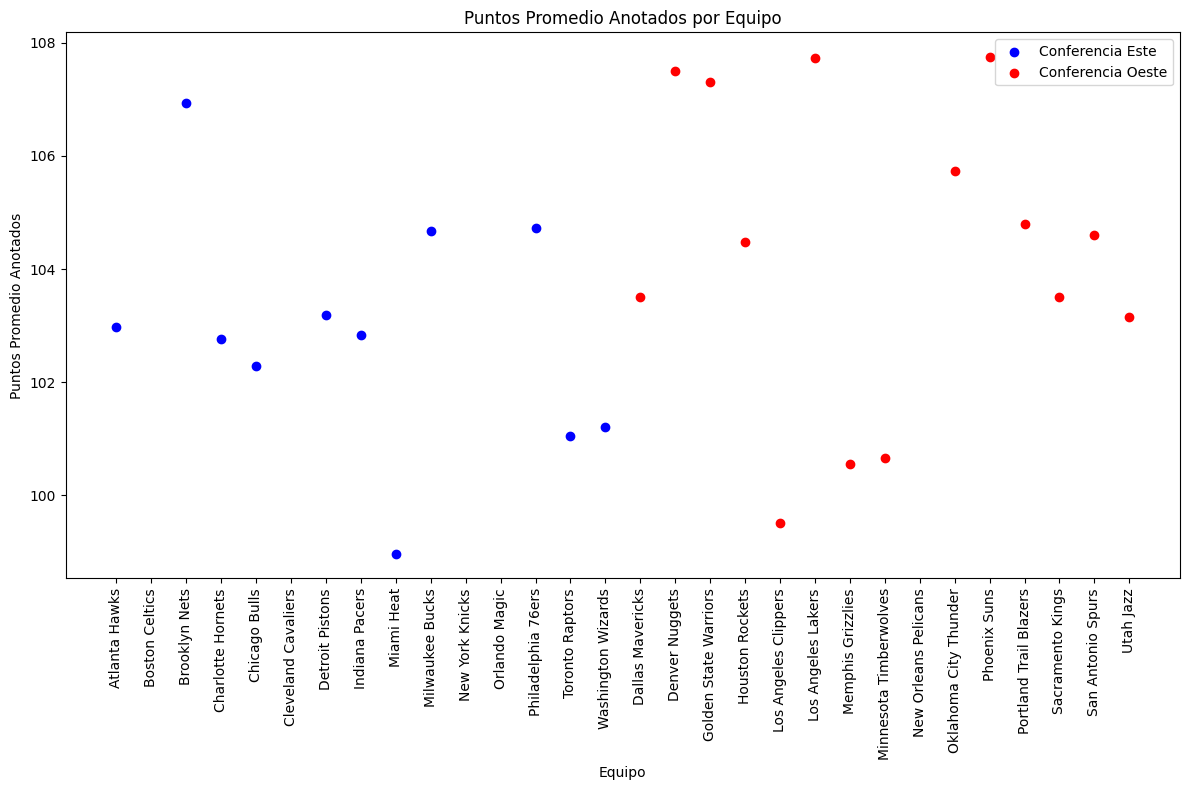

In [19]:
# Crear figura y ejes para el gráfico de dispersión
plt.figure(figsize=(12, 8))

# Gráfico de dispersión para la Conferencia Este
plt.scatter(kpi_df_este['Team'], kpi_df_este['Avg_Points_Scored'], color='blue', label='Conferencia Este')

# Gráfico de dispersión para la Conferencia Oeste
plt.scatter(kpi_df_oeste['Team'], kpi_df_oeste['Avg_Points_Scored'], color='red', label='Conferencia Oeste')

# Configuración de etiquetas y título
plt.title('Puntos Promedio Anotados por Equipo')
plt.xlabel('Equipo')
plt.ylabel('Puntos Promedio Anotados')
plt.xticks(rotation=90)
plt.legend()

# Guardar figura y mostrar el gráfico
plt.tight_layout()
plt.savefig('avg_points_scored_scatter.png')
plt.show()


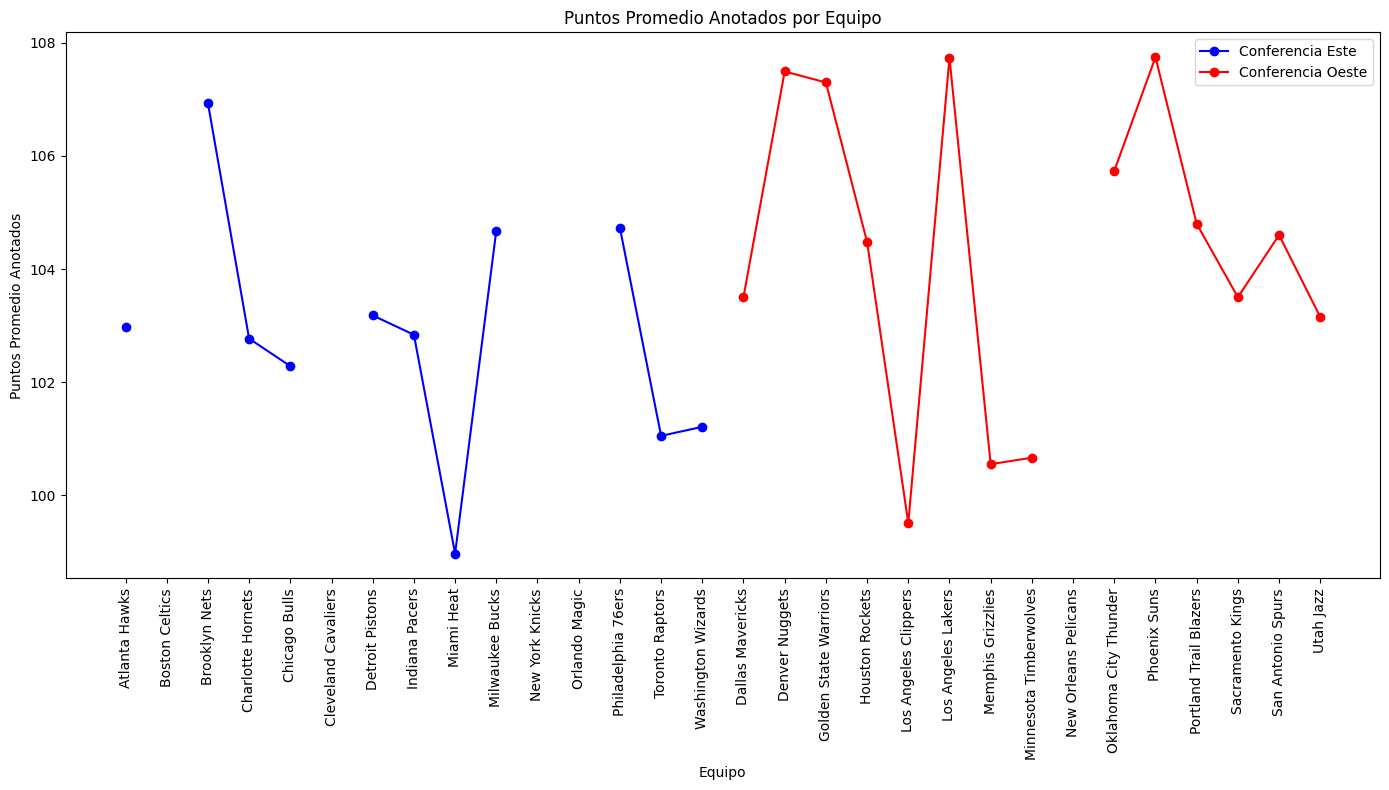

In [20]:
# Crear figura y ejes para el gráfico de líneas
plt.figure(figsize=(14, 8))

# Gráfico de líneas para la Conferencia Este
plt.plot(kpi_df_este['Team'], kpi_df_este['Avg_Points_Scored'], marker='o', linestyle='-', color='blue', label='Conferencia Este')

# Gráfico de líneas para la Conferencia Oeste
plt.plot(kpi_df_oeste['Team'], kpi_df_oeste['Avg_Points_Scored'], marker='o', linestyle='-', color='red', label='Conferencia Oeste')

# Configuración de etiquetas y título
plt.title('Puntos Promedio Anotados por Equipo')
plt.xlabel('Equipo')
plt.ylabel('Puntos Promedio Anotados')
plt.xticks(rotation=90)
plt.legend()

# Guardar figura y mostrar el gráfico
plt.tight_layout()
plt.savefig('avg_points_scored_lines.png')
plt.show()


Este código crea dos gráficos de barras colocados lado a lado que muestran los puntos promedio anotados por cada equipo en la Conferencia Este y Oeste de la NBA. Estos gráficos permiten comparar el rendimiento ofensivo de los equipos dentro de sus respectivas conferencias.

#### Qué Mide el Gráfico

1. **Average Points Scored por Equipo**:
   - **Conferencia Este**: El primer gráfico muestra los puntos promedio anotados por cada equipo de la Conferencia Este.
   - **Conferencia Oeste**: El segundo gráfico muestra los puntos promedio anotados por cada equipo de la Conferencia Oeste.

#### Importancia del Indicador

1. **Evaluación del Rendimiento Ofensivo**:
   - **Comparación Interna**: Permite a los equipos compararse dentro de su propia conferencia y ver cómo se posicionan en términos de capacidad ofensiva.
   - **Comparación Externa**: Facilita la comparación entre las dos conferencias, proporcionando una visión global del rendimiento ofensivo.

2. **Estrategia y Tácticas de Juego**:
   - **Identificación de Equipos Ofensivos Fuertes**: Equipos con un alto promedio de puntos anotados suelen ser los más potentes ofensivamente y pueden ser considerados más peligrosos en partidos de alta puntuación.
   - **Análisis de Competencia**: Equipos y analistas pueden usar este indicador para estudiar a los equipos más fuertes ofensivamente y adaptar sus estrategias defensivas.

3. **Planificación de Futuras Temporadas**:
   - **Decisiones de Gestión**: La dirección del equipo puede usar esta información para tomar decisiones sobre fichajes de jugadores ofensivos, cambios de entrenadores y otras decisiones estratégicas para mejorar su capacidad de anotación.



### Gráfico 3
Puntos Promedio Permitidos por Equipo - Conferencia Este

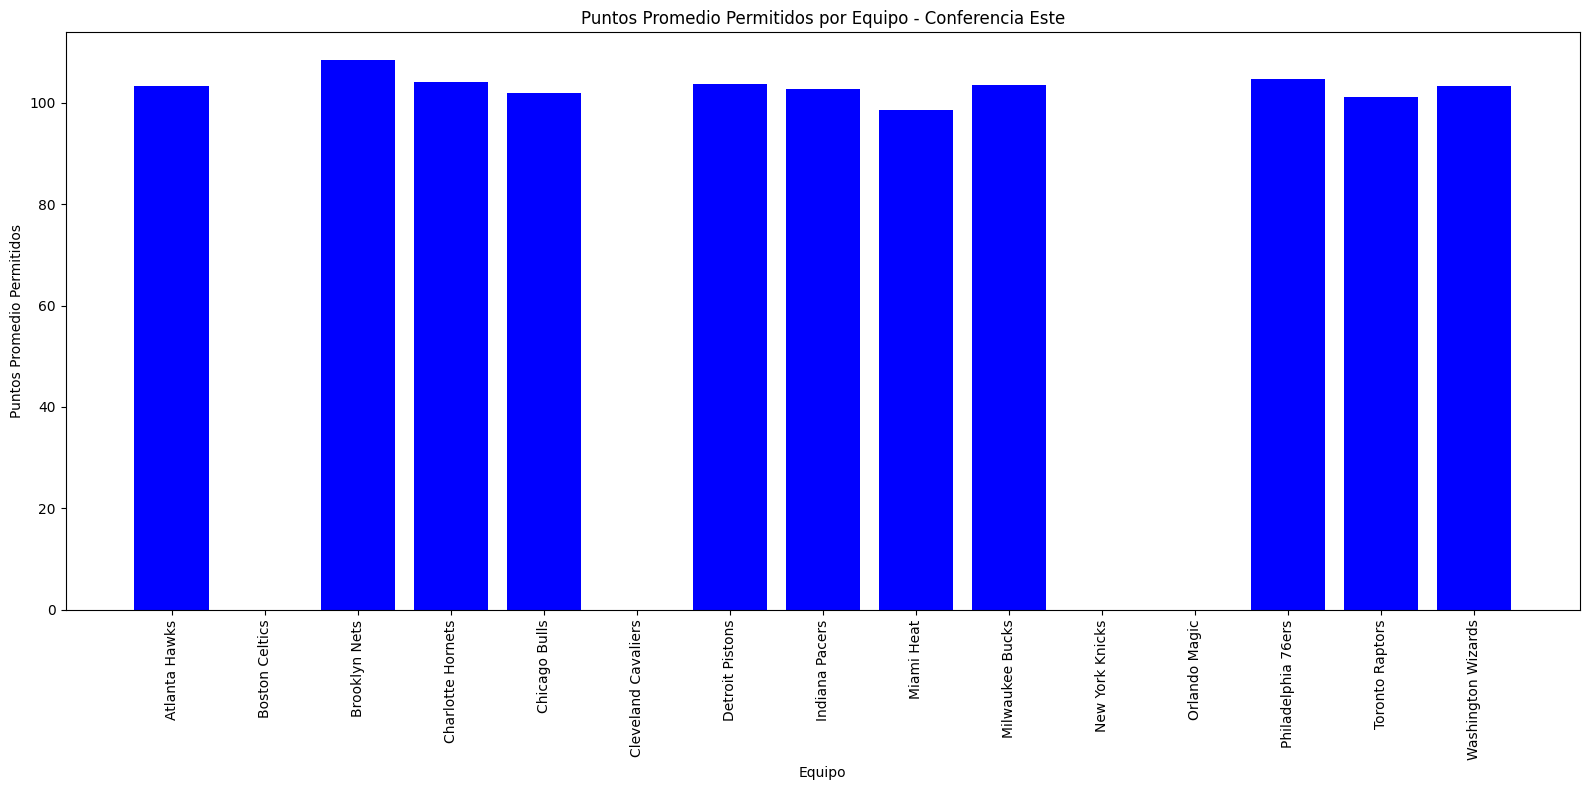

In [23]:
# Filtrar datos para la Conferencia Este
kpi_df_este = kpi_df[kpi_df['Conference'] == 'Este']

# Gráfico para la Conferencia Este
plt.figure(figsize=(16, 8))
plt.bar(kpi_df_este['Team'], kpi_df_este['Avg_Points_Allowed'], color='blue')
plt.title('Puntos Promedio Permitidos por Equipo - Conferencia Este')
plt.xlabel('Equipo')
plt.ylabel('Puntos Promedio Permitidos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('avg_points_allowed_este.png')
plt.show()


Puntos Promedio Permitidos por Equipo - Conferencia Oeste

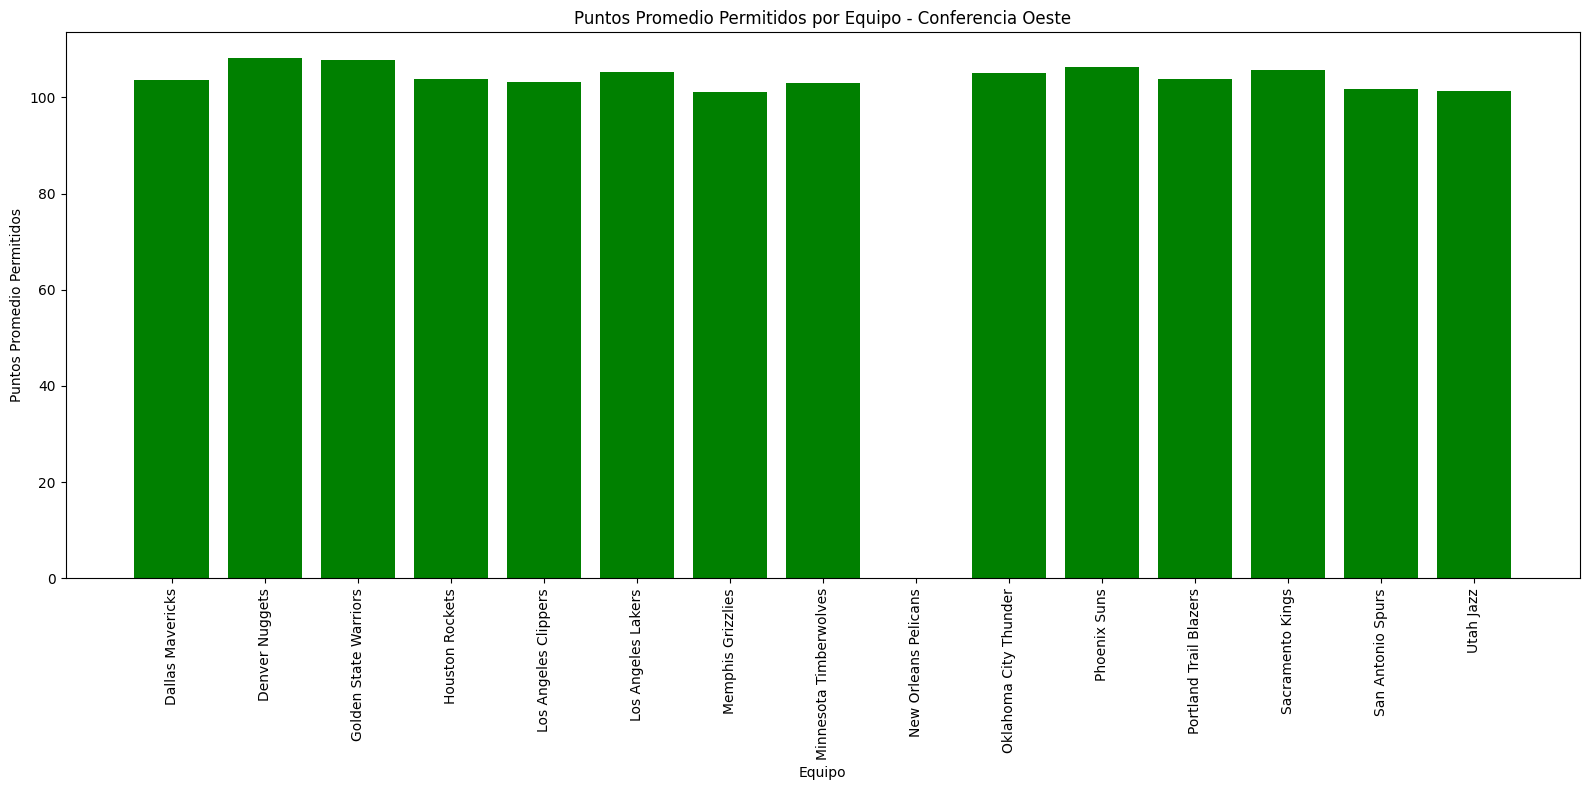

In [24]:
# Filtrar datos para la Conferencia Oeste
kpi_df_oeste = kpi_df[kpi_df['Conference'] == 'Oeste']

# Gráfico para la Conferencia Oeste
plt.figure(figsize=(16, 8))
plt.bar(kpi_df_oeste['Team'], kpi_df_oeste['Avg_Points_Allowed'], color='green')
plt.title('Puntos Promedio Permitidos por Equipo - Conferencia Oeste')
plt.xlabel('Equipo')
plt.ylabel('Puntos Promedio Permitidos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('avg_points_allowed_oeste.png')
plt.show()


Este gráfico mide los puntos promedio permitidos por cada equipo en la Conferencia Oeste de la NBA. Este indicador representa la cantidad promedio de puntos que los equipos permiten anotar a sus oponentes en los partidos.

#### Importancia del Indicador

1. **Medición del Rendimiento Defensivo**:
   - **Capacidad Defensiva**: Equipos que permiten menos puntos son generalmente considerados como equipos con una defensa más fuerte.
   - **Estrategia de Juego**: Un buen rendimiento defensivo puede ser indicativo de una estrategia de juego eficaz que impide a los oponentes anotar fácilmente.

2. **Impacto en el Éxito del Equipo**:
   - **Victorias y Derrotas**: Equipos con una defensa sólida y que permiten menos puntos a menudo tienen mayores probabilidades de ganar partidos.
   - **Clasificación en la Liga**: Un menor promedio de puntos permitidos puede correlacionarse con una mejor posición en la clasificación de la liga.

3. **Planificación de Entrenamientos y Mejoras**:
   - **Identificación de Áreas de Mejora**: Analizar los puntos permitidos puede ayudar a los entrenadores a identificar debilidades en la defensa y planificar entrenamientos específicos para mejorar estas áreas.
   - **Estrategias de Reforzamiento**: Equipos que permiten muchos puntos pueden buscar reforzar su defensa mediante fichajes o cambios tácticos.

4. **Comparaciones y Benchmarking**:
   - **Comparación con Otros Equipos**: Los equipos pueden compararse con sus rivales para entender dónde se encuentran en términos de rendimiento defensivo.
   - **Historial de Rendimiento**: Analizar este indicador a lo largo del tiempo puede mostrar tendencias y cambios en el rendimiento defensivo de un equipo.


### Gráfico 4
Asistencia promedio a los partidos de cada equipo en las conferencias Este y Oeste de la NBA.

C:\Users\Personal Computer\AppData\Local\Temp\ipykernel_9620\2391464420.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(kpi_df_este['Team'], rotation=90)
C:\Users\Personal Computer\AppData\Local\Temp\ipykernel_9620\2391464420.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(kpi_df_oeste['Team'], rotation=90)


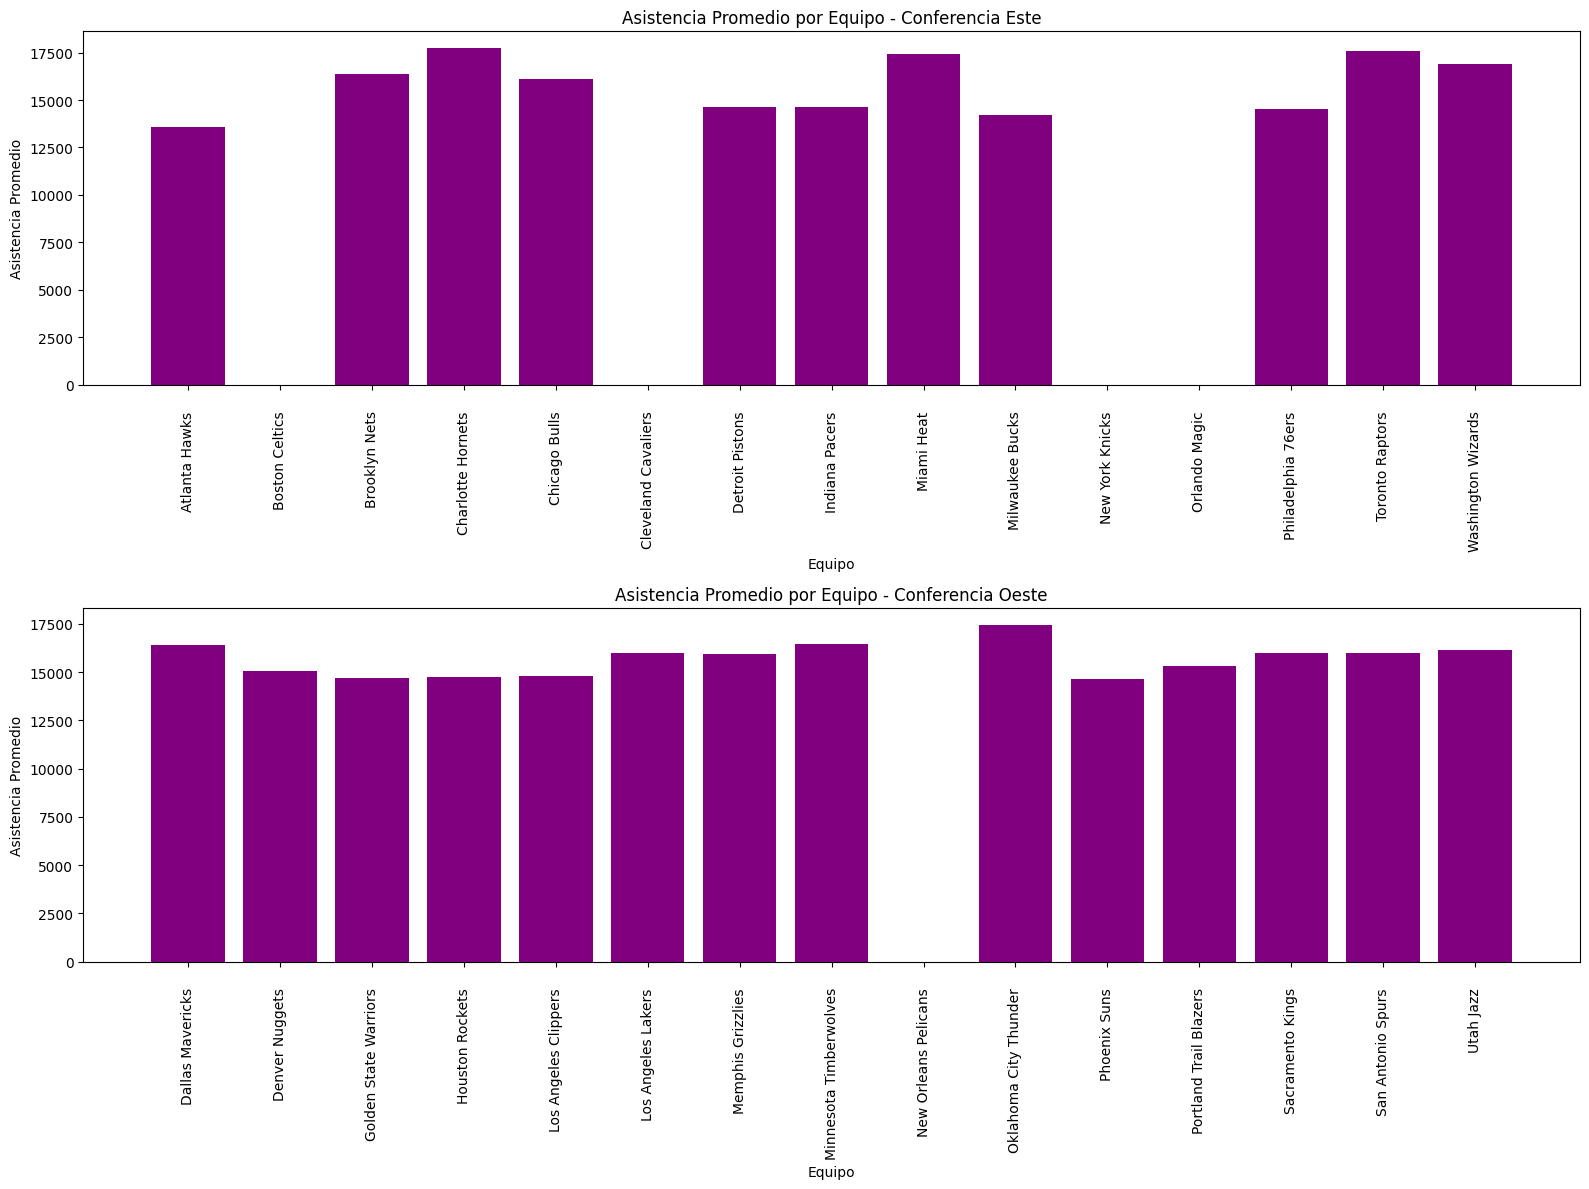

In [25]:
# Filtrar datos para la Conferencia Este y Conferencia Oeste
kpi_df_este = kpi_df[kpi_df['Conference'] == 'Este']
kpi_df_oeste = kpi_df[kpi_df['Conference'] == 'Oeste']

# Crear subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

# Gráfico para la Conferencia Este
ax1.bar(kpi_df_este['Team'], kpi_df_este['Avg_Attendance'], color='purple')
ax1.set_title('Asistencia Promedio por Equipo - Conferencia Este')
ax1.set_xlabel('Equipo')
ax1.set_ylabel('Asistencia Promedio')
ax1.set_xticklabels(kpi_df_este['Team'], rotation=90)
ax1.tick_params(axis='x', which='major', pad=15)

# Gráfico para la Conferencia Oeste
ax2.bar(kpi_df_oeste['Team'], kpi_df_oeste['Avg_Attendance'], color='purple')
ax2.set_title('Asistencia Promedio por Equipo - Conferencia Oeste')
ax2.set_xlabel('Equipo')
ax2.set_ylabel('Asistencia Promedio')
ax2.set_xticklabels(kpi_df_oeste['Team'], rotation=90)
ax2.tick_params(axis='x', which='major', pad=15)

# Ajustar diseño y guardar gráfico
plt.tight_layout()
plt.savefig('avg_attendance_conferencias.png')
plt.show()


Este gráfico mide la asistencia promedio a los partidos de cada equipo en las conferencias Este y Oeste de la NBA. Este indicador representa la cantidad promedio de espectadores que asisten a los partidos de un equipo.

#### Importancia del Indicador

1. **Medición de la Popularidad del Equipo**:
   - **Popularidad Local**: Equipos con altas asistencias promedio tienden a tener una base de aficionados local fuerte y leal.
   - **Engagement de los Aficionados**: La asistencia promedio puede reflejar cómo de comprometidos y apasionados están los aficionados con su equipo.

2. **Impacto Financiero**:
   - **Ingresos por Entradas**: Un mayor número de espectadores generalmente se traduce en mayores ingresos por venta de entradas.
   - **Ingresos por Concesiones y Merchandising**: A mayor asistencia, mayores oportunidades para vender productos y concesiones en el estadio.

3. **Influencia en el Rendimiento del Equipo**:
   - **Ventaja de Jugar en Casa**: Equipos que juegan en estadios llenos pueden beneficiarse del apoyo de la multitud, lo que puede tener un impacto positivo en su rendimiento.

4. **Estrategias de Marketing y Promoción**:
   - **Eficiencia de las Campañas**: Equipos con menor asistencia pueden analizar estos datos para mejorar sus estrategias de marketing y promociones.
   - **Patrocinadores y Socios**: Un estadio lleno puede ser más atractivo para patrocinadores y socios comerciales.

5. **Planificación de Infraestructuras**:
   - **Mejoras en el Estadio**: Equipos con altas asistencias pueden justificar inversiones en mejoras de infraestructura, como asientos, servicios, y comodidades para los aficionados.
